In [16]:
#%pip install keras
#%pip install tensorflow
import keras
keras.__version__

'3.12.0'

# Movie review classification: a binary classification example

This notebook contains code examples adapted from Chapter 3, Section 5 of the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). The original text includes much more explanation and figures; here you will find the code and concise accompanying comments.

----

Binary classification is one of the most commonly applied types of machine learning problems. In this example we'll learn how to classify movie reviews as "positive" or "negative", based only on the review text.

## The IMDB dataset

We will work with the IMDB dataset: 50,000 highly polarized movie reviews from the Internet Movie Database. The dataset is split into 25,000 reviews for training and 25,000 for testing, with each set containing 50% negative and 50% positive reviews.

Why separate training and test sets? You should never evaluate a machine learning model on the same data you trained it on. Strong performance on the training set does not guarantee good performance on unseen data — what you care about is how the model performs on new examples. For example, a model could simply memorize the mapping from training inputs to targets, which would not help predict labels for previously unseen data. We'll discuss this in more detail later.

Like MNIST, the IMDB dataset is bundled with Keras and comes preprocessed: reviews (sequences of words) are encoded as sequences of integers, where each integer represents a specific word in a dictionary.

The code below will load the dataset (the first run downloads about 80MB of data):

In [17]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The argument `num_words=10000` keeps only the top 10,000 most frequently occurring words in the training data; rare words are discarded. This lets us work with vector data of reasonable size.

The variables `train_data` and `test_data` are lists of reviews, where each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s: 0 = negative, 1 = positive.

Note on problem types:
- multiclass: multiple classes (more than two)
- multilabel: each instance can have multiple labels

Each review is represented as a list of word indices. If `train_data` is the training set, each element of `train_data` is a list of indices corresponding to the words in that review.

In [18]:
train_data.shape

(25000,)

In [19]:
import numpy as np
np.unique(train_labels) # We only have two classes: positive and negative

array([0, 1], dtype=int64)

Since we limited to 10,000 words, no word index will exceed 10,000.

In [20]:
max([max(sequence) for sequence in train_data]) #code of the word which is 10000

9999

For fun, here is how you can quickly decode one of these reviews back to English words:

In [21]:
# `word_index` is a dictionary mapping words to integer indices
word_index = imdb.get_word_index()
# Reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Decode the review; note that our indices are offset by 3
# because 0, 1, and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[19]])

In [22]:
decoded_review

"? chances are is a charming romantic fantasy about a woman ? shepherd whose husband christopher ? is killed shortly after learning she is pregnant we then see the husband in heaven letting the powers that be know that he was taken too soon and that his wife needs him he is told he can return to earth but not as himself ? 19 years where we see ? daughter mary stuart masterson preparing to graduate from college and ? a young man robert downey jr who it turns out is the reincarnation of her father the film is a little on the predictable side the story goes all the places you expect it to but it is so ? played by an energetic cast especially shepherd and downey that you can't help but get wrapped up in the fun shepherd has rarely been seen on screen to better advantage and she and downey are backed by a talented group of character actors in supporting roles a lovely and charming fantasy that will ? and ? you"

## Preparing the data

We cannot feed lists of integers directly into a neural network; we must turn our lists into tensors. There are two common approaches:

* Pad the sequences so they all have the same length and feed an integer tensor of shape `(samples, word_indices)` to a model whose first layer can handle integer sequences (for example, an `Embedding` layer).

* One-hot encode the sequences into vectors of 0s and 1s. For example, turn the sequence `[3, 5]` into a 10,000-dimensional vector that is all zeros except for ones at indices 3 and 5; then use a `Dense` layer as your first layer.

We'll use the second approach here and vectorize the data manually for clarity.

In [23]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

'''Converted the dataset from a list-of-word-indices format, e.g.
review1  [word_index_list]  label
review2  [word_index_list]  label
...
to a matrix of 0/1 vectors (one-hot encoded word presence) and labels.
'''

'Converted the dataset from a list-of-word-indices format, e.g.\nreview1  [word_index_list]  label\nreview2  [word_index_list]  label\n...\nto a matrix of 0/1 vectors (one-hot encoded word presence) and labels.\n'

Here is how our instances look now:

In [24]:
x_train.shape # We have 10,000 possible words; reviews are represented as length-10000 vectors where 1s mark words present in the review

(25000, 10000)

We also need to vectorize our labels, which is straightforward:

In [25]:
# Our vectorized labels
# It is important that input sequences have consistent shape so weight multiplication works with matching dimensions
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data are ready to be fed into a neural network.

## Building our network

Our input data are simply vectors, and our labels are scalars (1 and 0): this is the simplest setup you will ever encounter. A type of network that would work well for such a problem is a simple stack of fully connected (Dense) layers with ReLU activations: `Dense(16, activation='relu')`.

The argument passed to each `Dense` layer (16) is the number of "hidden units" in that layer. What is a hidden unit? It is the dimensionality of the layer’s representation space. You may recall from the previous chapter that such a `Dense` layer with a ReLU activation implements the following chain of tensor operations:

output = relu(dot(W, input) + b)

Having 16 hidden units means the weight matrix W will have shape `(input_dim, 16)`, i.e. the dot product with W will project the input data into a 16-dimensional representation space (then we add the bias vector b and apply the ReLU). Intuitively, you can think of the dimensionality of your representation space as how much freedom you allow the network to have when learning internal representations. More hidden units (a higher-dimensional representation space) allow the network to learn more complex representations, but they also make the network more computationally expensive and can lead to learning unwanted patterns (patterns that improve training performance but do not generalize to test data).

There are two key architectural decisions to make regarding such a stack of dense layers:

* How many layers to use.
* How many "hidden units" to choose for each layer.

In the next chapter you will learn formal principles to guide these choices. For now, you will have to trust the following architectural choice:
two hidden layers with 16 hidden units each,
and a third layer that will give a scalar prediction for the sentiment of the current review.
The hidden layers will use ReLU as their activation function,
and the final layer will use a sigmoid activation to output a probability
(a score between 0 and 1 that indicates how likely the sample’s target is "1", i.e. how likely the review is positive).
ReLU (rectified linear unit) is a function that sets negative values to zero,
while the sigmoid function "squashes" arbitrary values into the interval [0, 1], producing something that can be interpreted as a probability.


**First hidden layer: 16 units; second hidden layer: 16 units; final layer: 1 unit because the output is binary. `Sequential` means that the layers communicate sequentially.**

Here is what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

Below is the Keras implementation, similar to the MNIST example:

In [26]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,))) #activation function, relu is the most popular, there is also sigmoid and tanh
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In the end, we must choose a loss function and an optimizer. Since we are dealing with a binary classification problem and the network’s output is a probability (we end the network with a single-unit layer and a sigmoid activation), it is best to use the `binary_crossentropy` loss function. This is not the only viable choice: you could use, for example, `mean_squared_error`. But crossentropy is usually the best choice when working with models that output probabilities. Crossentropy is a quantity from information theory that measures the "distance" between probability distributions, or in our case, between the true distribution and our predictions.

Here are the steps where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will also monitor accuracy during training.

In [27]:
model.compile(optimizer='rmsprop', #when we define a neural network, we also define how we will train it, the optimization algorithm, the loss metric we want to minimize, and the metric we track is accuracy
              loss='binary_crossentropy',
              metrics=['accuracy'])

Our optimizer, loss function, and metrics are passed as strings, which is possible because `rmsprop`, `binary_crossentropy`, and `accuracy` are bundled with Keras. Sometimes you may want to configure parameters of your optimizer, or pass a custom loss function or metric. The former can be done by passing an instance of the optimizer class as the `optimizer` argument:

In [28]:
from keras import optimizers #you can also optimize this way, by loading the optimizer, here we have the learning rate, like alpha in the Armijo condition

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), #in some versions of keras the learning_rate parameter is called lr
              loss='binary_crossentropy',
              metrics=['accuracy'])

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [29]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validation of our approach

To monitor the model's accuracy on data it has never seen before during training, we will create a "validation set" by setting aside 10,000 samples from the original training data:

In [30]:
#it is important to also split into validation so that we do not overfit the model by training it on training/test and to find optimal parameters

x_val = x_train[:10000] #from the training set of 25k we take 10k for validation
partial_x_train = x_train[10000:] #the rest for training

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Now we'll train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 samples. At the same time we'll monitor the loss and accuracy on the 10,000 samples we set aside. This is done by passing the validation data as the `validation_data` argument:

In [31]:
history = model.fit(partial_x_train, #english training, number of epochs is number of iterations
                    partial_y_train,
                    epochs=20,
                    batch_size=512, #represents the number of samples after which we update the weight factors, why don't we update only after passing all data, because it is memory intensive
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - binary_accuracy: 0.7800 - loss: 0.5105 - val_binary_accuracy: 0.8670 - val_loss: 0.3848
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8975 - loss: 0.3123 - val_binary_accuracy: 0.8835 - val_loss: 0.3080
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9229 - loss: 0.2355 - val_binary_accuracy: 0.8858 - val_loss: 0.2848
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9355 - loss: 0.1927 - val_binary_accuracy: 0.8871 - val_loss: 0.2767
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.9496 - loss: 0.1616 - val_binary_accuracy: 0.8821 - val_loss: 0.2946
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9555 - loss: 0.1379 - val_binary_accuracy: 0.8886 - val_loss: 0.2850
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.9641 - loss: 0.1191 - val_binary_accuracy: 0.8854 - val_loss: 0.2979
Epoch 8/20
30/30 ━━

If the validation loss is going down, that's a good sign.

On a CPU, this will take less than two seconds per epoch — training finishes in about 20 seconds. At the end of each epoch there is a short pause while the model computes its loss and accuracy on the 10,000 validation samples.

Note that the call to `model.fit()` returns a `History` object. This object has an attribute history, which is a dictionary containing data about everything that happened during training. Let's look at it:

In [32]:
history_dict = history.history
history_dict.keys() #dictionary that recorded all those values during those 20 iterations

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

It contains four entries: one for each metric tracked during training and validation. Let's use Matplotlib to plot training and validation loss and training and validation accuracy side by side:

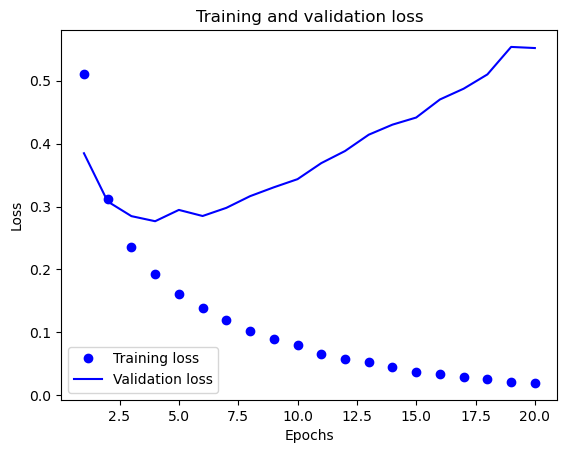

In [39]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy'] #depending on which compile is run, if it is the other then it is binary_accuracy
val_acc = history.history['val_binary_accuracy'] #here it is val_binary_accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

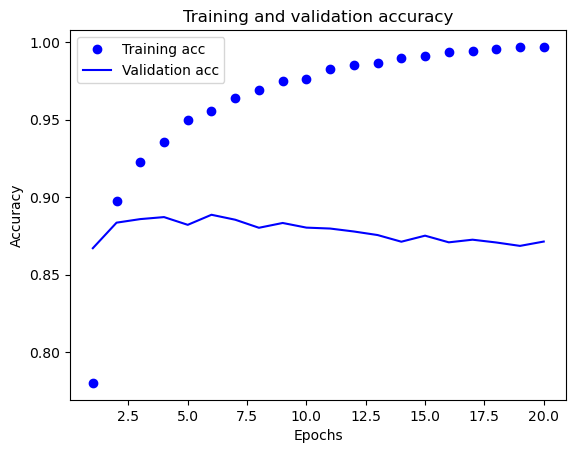

In [40]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Dots show training loss and training accuracy, while solid lines show loss and accuracy on the validation set. Note that your results may vary slightly due to different random initialization of your network.

As you can see, training loss decreases with each epoch and training accuracy increases with each epoch. This is what you would expect when running gradient descent optimization — the quantity you are trying to minimize should decrease with each iteration. But this is not the case for validation loss and accuracy: they appear to peak at the fourth epoch. This is an example of what we warned about earlier: a model that performs better on the training data is not necessarily the model that will perform better on data it has never seen before. More precisely, what you are seeing is overfitting: after the second epoch we are over-optimizing on the training data and end up learning representations that are specific to the training set and do not generalize to data outside the training set.

In this case, to prevent overfitting we could simply stop training after three epochs. In general, there are a number of techniques you can apply to mitigate overfitting, which we will cover in the next chapter.

Let’s train a new network from scratch for four epochs, and then evaluate it on our test data:

In [35]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7184 - loss: 0.5728
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8994 - loss: 0.2964
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9236 - loss: 0.2188
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9341 - loss: 0.1857
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8838 - loss: 0.2900


In [36]:
results

[0.2904219627380371, 0.8850399851799011]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art methods, you should be able to reach close to 95%.

## Using the trained network to generate predictions on new data

After you have trained the network, you'll want to use it in a practical setting. You can generate the probability that reviews are positive using the `predict` method:

In [ ]:
predictions = model.predict(x_test) #this gives us probabilities, not numbers

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


As you can see, the network is very confident for some samples (0.99 or higher, or 0.01 or lower), but less confident for others (0.6, 0.4).

In [ ]:
np.round(predictions) #predictions based on words, whether the review is positive or negative

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

## Further experiments

* We used 2 hidden layers. Try using 1 or 3 hidden layers and see how that affects validation and test accuracy.

* Try using layers with more or fewer hidden units: 32 units, 64 units, etc.

* Try using the MSE loss function instead of `binary_crossentropy`.

* Try using the `tanh` activation function (an activation that was popular in the early days of neural networks) instead of `relu`.

These experiments will help you verify that the architectural choices we made are fairly reasonable, although they can still be improved.

In [39]:
predictions.shape

(25000, 1)

Instead of accuracy we can also use recall

## Conclusion

Here is what you should remember from this example:

*   It usually takes a lot of preprocessing of raw data to be able to feed them — as tensors — into a neural network. In the case of word sequences, they can be encoded as binary vectors — but there are other encoding options.

*   Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will likely use them often.

*   In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation; i.e., the network’s output should be a scalar between 0 and 1 that encodes a probability.

*   With such a scalar sigmoid output, for binary classification you should use the `binary_crossentropy` loss function.

*   The `rmsprop` optimizer is generally a good default choice. That’s one less thing to worry about.

As models get better on the training data, neural networks eventually begin to overfit and end up performing worse on data they have never seen before. Always make sure to monitor performance on data outside the training set.